In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc
import datetime
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler

In [2]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_transaction=pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [4]:
train_df = train_transaction.merge(train_identity, how="left", on="TransactionID")

test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [5]:
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

# Reduce Memory

In [6]:
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# train_df = reduce_mem_usage(train_df)
# test_df  = reduce_mem_usage(test_df)

# Useless From Eda

In [8]:
train_df.drop(['M1','id_27','V1','V14','V41','V68','V305'],inplace=True,axis=1)
test_df.drop(['M1','id_27','V1','V14','V41','V68','V305'],inplace=True,axis=1)

# Some Outliers

In [9]:
# droptamt = train_df[train_df['TransactionAmt']>10000].index
# train_df.drop(droptamt, inplace=True)

# dropdist1 = train_df[train_df['dist1']>6000].index
# train_df.drop(dropdist1, inplace=True)

# dropdist2 = train_df[train_df['dist2']>8000].index
# train_df.drop(dropdist2, inplace=True)

# dropc1 = train_df[train_df['C1'] > 2000].index
# train_df.drop(dropc1, inplace=True)

# dropc2 = train_df[train_df['C2'] > 2000].index
# train_df.drop(dropc2, inplace=True)

# #dropping the -ve values
# dropd4 = train_df[train_df['D4']<0].index
# train_df.drop(dropd4, inplace=True)

# dropd6 = train_df[train_df['D6']<0].index
# train_df.drop(dropd6, inplace=True)

# dropd11 = train_df[train_df['D11']<0].index
# train_df.drop(dropd11, inplace=True)

# dropd12 = train_df[train_df['D12']<0].index
# train_df.drop(dropd12, inplace=True)

# dropd14 = train_df[train_df['D14']<0].index
# train_df.drop(dropd14, inplace=True)

# dropd15 = train_df[train_df['D15']<0].index
# train_df.drop(dropd15, inplace=True)

In [10]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    
    if na_name:
        return na_columns,missing_df

In [11]:
na_cols,missing_df=missing_values_table(train_df, True)
missing_df.reset_index(inplace=True)

               n_miss  ratio
id_24          585793  99.20
id_25          585408  99.13
id_07          585385  99.13
id_08          585385  99.13
id_21          585381  99.13
id_26          585377  99.13
id_23          585371  99.12
id_22          585371  99.12
dist2          552913  93.63
D7             551623  93.41
id_18          545427  92.36
D13            528588  89.51
D14            528353  89.47
D12            525823  89.04
id_03          524216  88.77
id_04          524216  88.77
D6             517353  87.61
id_33          517251  87.59
id_10          515614  87.31
id_09          515614  87.31
D8             515614  87.31
D9             515614  87.31
id_30          512975  86.87
id_32          512954  86.86
id_34          512735  86.82
id_14          510496  86.45
V156           508595  86.12
V148           508595  86.12
V155           508595  86.12
V157           508595  86.12
V158           508595  86.12
V154           508595  86.12
V153           508595  86.12
V161          

# Feature Engineering

In [12]:
def feature_eng(dataframe,name=True):
    
    dataframe['hour'] = (dataframe['TransactionDT']/(3600))%24
    
    def hourFeature(hour):
        if hour > 3 and hour < 12:
            return "highalert"
        if hour > 18 and hour <= 23:
            return "mediumalert"
        else:
            return "lowalert"
        
    dataframe['alertFeature'] = dataframe['hour'].apply(hourFeature)
    
    dataframe['LogTransactionAmt'] = np.log(dataframe['TransactionAmt'])
    
    
    
    
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]
    if name:
        dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
        dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

        dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
        dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

        dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
        dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = "1"
    gc.collect()
    
    dataframe['c2_check']=dataframe["card2"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['c3_check']=dataframe["card3"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe["new_domain"]=dataframe['P_emaildomain'].apply(lambda x:str(x).partition(".")[0])
    dataframe['t_dt_minute']=dataframe["TransactionDT"]/60
    dataframe['t_dt_hour']=dataframe["t_dt_minute"]/60
    dataframe['t_dt_day']=dataframe["t_dt_hour"]/24
    dataframe['t_dt_week']=dataframe["t_dt_day"]/7

    # ADD MONTH FEATURE
    START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
    dataframe['DT_M'] = dataframe['TransactionDT'].map(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    dataframe['DT_M'] = (dataframe['DT_M'].dt.year-2017)*12 + dataframe['DT_M'].dt.month 

    dataframe['card1check']=dataframe["card1"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['card2check']=dataframe["card2"].apply(lambda x: 0 if np.isnan(x)  else 1)

    dataframe['D2_check']=dataframe["D2"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D3_check']=dataframe["D3"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D4_check']=dataframe["D4"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D5_check']=dataframe["D5"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D6_check']=dataframe["D6"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D7_check']=dataframe["D7"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['d8_check']=dataframe["D8"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D9_check']=dataframe["D9"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D10_check']=dataframe["D10"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D11_check']=dataframe["D11"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D12_check']=dataframe["D12"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D13_check']=dataframe["D13"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D14_check']=dataframe["D14"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D15_check']=dataframe["D15"].apply(lambda x: 0 if np.isnan(x)  else 1)

    dataframe["new_domain1"]=dataframe['P_emaildomain'].apply(lambda x:str(x).partition(".")[-1])
    dataframe["new_domain2"]=dataframe['R_emaildomain'].apply(lambda x:str(x).partition(".")[-1])
    
    dataframe["addr1_addr2"] = dataframe["addr1"] + dataframe["addr2"]
    dataframe["card1_card2"] = dataframe["card1"] + dataframe["card2"]
    
    dataframe['TransactionAmt_to_mean_card1'] = dataframe['TransactionAmt'] / dataframe.groupby(['card1'])['TransactionAmt'].transform('mean')
    dataframe['TransactionAmt_to_mean_card4'] = dataframe['TransactionAmt'] / dataframe.groupby(['card4'])['TransactionAmt'].transform('mean')
    dataframe['TransactionAmt_to_std_card1'] = dataframe['TransactionAmt'] / dataframe.groupby(['card1'])['TransactionAmt'].transform('std')
    dataframe['TransactionAmt_to_std_card4'] = dataframe['TransactionAmt'] / dataframe.groupby(['card4'])['TransactionAmt'].transform('std')

    dataframe['id_02_to_mean_card1'] = dataframe['id_02'] / dataframe.groupby(['card1'])['id_02'].transform('mean')
    dataframe['id_02_to_mean_card4'] = dataframe['id_02'] / dataframe.groupby(['card4'])['id_02'].transform('mean')
    dataframe['id_02_to_std_card1'] = dataframe['id_02'] / dataframe.groupby(['card1'])['id_02'].transform('std')
    dataframe['id_02_to_std_card4'] = dataframe['id_02'] / dataframe.groupby(['card4'])['id_02'].transform('std')

    dataframe['D15_to_mean_card1'] = dataframe['D15'] / dataframe.groupby(['card1'])['D15'].transform('mean')
    dataframe['D15_to_mean_card4'] = dataframe['D15'] / dataframe.groupby(['card4'])['D15'].transform('mean')
    dataframe['D15_to_std_card1'] = dataframe['D15'] / dataframe.groupby(['card1'])['D15'].transform('std')
    dataframe['D15_to_std_card4'] = dataframe['D15'] / dataframe.groupby(['card4'])['D15'].transform('std')

    dataframe['D15_to_mean_addr1'] = dataframe['D15'] / dataframe.groupby(['addr1'])['D15'].transform('mean')
    dataframe['D15_to_std_addr1'] = dataframe['D15'] / dataframe.groupby(['addr1'])['D15'].transform('std')
    
    return dataframe

In [13]:
train_df = feature_eng(train_df)

In [14]:
test_df = feature_eng(test_df)

# Drop Useless Features

In [15]:
# useless = ['V22','V27','V28','V31', 'V34', 'V100', 'V39', 'V125', 'V122', 'V50', 'V119', 'V118', 'V117', 'V116', 'V114', 'V113', 'V57',
#            'V58', 'V110', 'V65', 'V107', 'V71', 'V21', 'V18', 'V16', 'V89', 'V88', 'V321', 'V93']

In [16]:
# reduce = [col for col in train_df.columns if col not in useless] 

In [17]:
# reduce_test = [col for col in train_df.columns if col not in useless and col not in ["isFraud"]] 

In [18]:
# train_df = train_df[reduce]

In [19]:
# test_df = test_df[reduce_test]

# I Converted Infinity Values to Nan

In [20]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop variables that are missing more than 60% 

In [21]:
drop_variables=missing_df[missing_df["ratio"]>60]['index']

In [22]:
# train_df.drop(drop_variables,inplace=True,axis=1)


In [23]:
# test_df.drop(drop_variables,inplace=True,axis=1)

# Filling Missing Values


In [24]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [25]:
train_df.isnull().sum()

TransactionID                   0
isFraud                         0
TransactionDT                   0
TransactionAmt                  0
ProductCD                       0
card1                           0
card2                           0
card3                           0
card4                           0
card5                           0
card6                           0
addr1                           0
addr2                           0
dist1                           0
dist2                           0
P_emaildomain                   0
R_emaildomain                   0
C1                              0
C2                              0
C3                              0
C4                              0
C5                              0
C6                              0
C7                              0
C8                              0
C9                              0
C10                             0
C11                             0
C12                             0
C13           

# Label Encoder

In [26]:
for f in train_df.columns:
    if train_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values)) 

In [27]:
for f in test_df.columns:
    if test_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

# Reduce Memory Again

In [28]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 568.81 Mb (73.8% reduction)


In [29]:
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 495.30 Mb (73.4% reduction)


# Model

In [30]:
y = train_df["isFraud"]
X = train_df.drop(["isFraud", "TransactionID"], axis=1)
test_df = test_df.drop(["TransactionID"], axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Random Under Sampling

In [32]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train==0)))

undersample = RandomUnderSampler(sampling_strategy=0.2, random_state=3)

X_train_res, y_train_res = undersample.fit_resample(X, y)

print('After UnderSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before UnderSampling, counts of label '1': 14464
Before UnderSampling, counts of label '0': 398914 

After UnderSampling, the shape of train_X: (123978, 479)
After UnderSampling, the shape of train_y: (123978,) 

After UnderSampling, counts of label '1': 20663
After UnderSampling, counts of label '0': 103315


# lightgbm

In [33]:
reg3 = LGBMClassifier(objective='binary',
                    boosting_type='gbdt',
                    metric='auc',
                    n_jobs=-1,
                    learning_rate=0.01,
                    num_leaves= 2**8,
                    max_depth=-1,
                    tree_learner='serial',
                    colsample_bytree= 0.7,
                    subsample_freq=1,
                    subsample=0.7,
                    n_estimators=800,
                    max_bin=255,
                    verbose=-1) 
reg3.fit(X_train_res,y_train_res) 

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, max_bin=255,
               metric='auc', n_estimators=800, num_leaves=256,
               objective='binary', subsample=0.7, subsample_freq=1,
               tree_learner='serial', verbose=-1)

In [34]:
pred3 = reg3.predict(X_test)  
print(classification_report(y_test, pred3))
print(f"Auc: {round(roc_auc_score(pred3, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    170963
           1       0.78      0.85      0.81      6199

    accuracy                           0.99    177162
   macro avg       0.89      0.92      0.90    177162
weighted avg       0.99      0.99      0.99    177162

Auc: 0.89


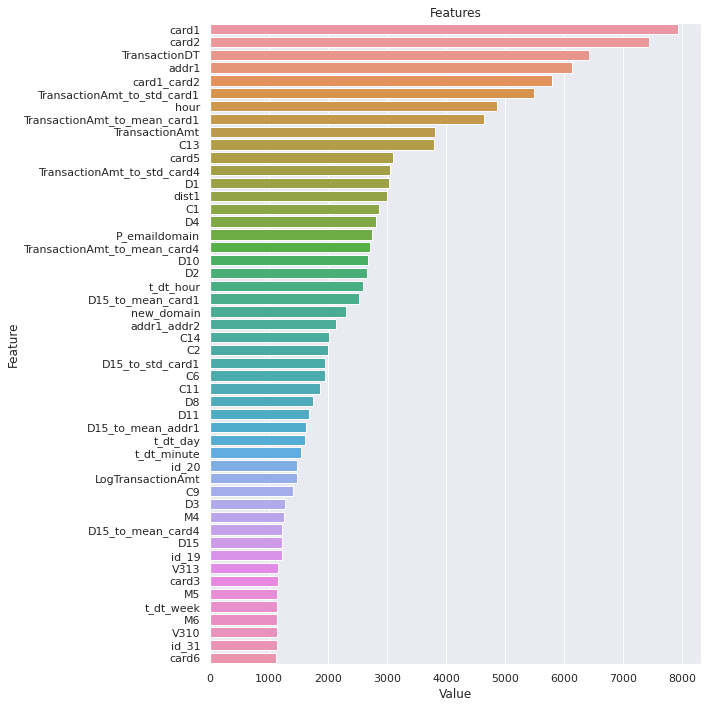

In [35]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:50])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
        
plot_importance(reg3, X_train)

In [36]:
predictions3 = reg3.predict_proba(test_df)[:,1]

In [37]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':predictions3})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.011574
1,3663550,0.017660
2,3663551,0.039558
3,3663552,0.017004
4,3663553,0.012803


In [38]:
filename = 'CIS Fraud Detection under sampling lgbm.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection under sampling lgbm.csv


In [39]:
# feature_imp = pd.DataFrame({'Value': reg3.feature_importances_, 'Feature': X_train.columns}).sort_values(by="Value")
# feature_imp

In [40]:
# Score: 0.909003
# Public score: 0.938276

# xgb

In [41]:
reg4 = XGBClassifier(n_estimators=500,
              max_depth=9,
              learning_rate=0.05,
              subsample=0.9,
              colsample_bytree=0.9,
              gamma = 0.2,
              alpha = 4,
              tree_method='hist')  
reg4.fit(X_train_res,y_train_res) 

[18:43:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=4, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [42]:
pred4 = reg4.predict(X_test)  
print(classification_report(y_test, pred4))
print(f"Auc: {round(roc_auc_score(pred4, y_test), 4)}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    170963
           1       0.77      0.85      0.81      6199

    accuracy                           0.99    177162
   macro avg       0.88      0.92      0.90    177162
weighted avg       0.99      0.99      0.99    177162

Auc: 0.8837


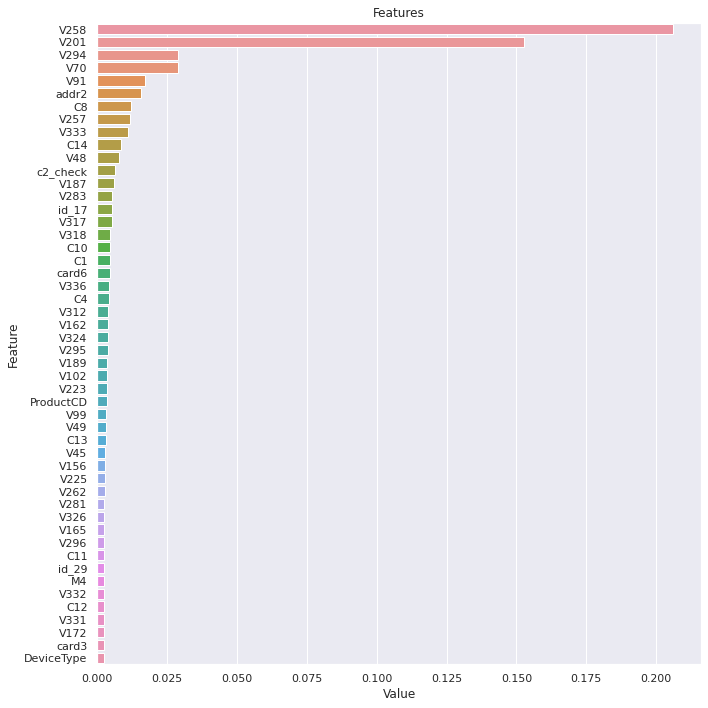

In [43]:
plot_importance(reg4, X_train)

In [44]:
predictions4 = reg4.predict_proba(test_df)[:,1]

In [45]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':predictions4})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.019272
1,3663550,0.013846
2,3663551,0.022876
3,3663552,0.021658
4,3663553,0.003555


In [46]:
filename = 'CIS Fraud Detection under sampling xgb.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection under sampling xgb.csv


In [47]:
# feature_imp = pd.DataFrame({'Value': reg4.feature_importances_, 'Feature': X_train.columns}).sort_values(by="Value")
# feature_imp

In [48]:
# Score: 0.906771
# Public score: 0.936787